# MIMIC-II IAC Patient Trajectory and Fate

In the previous [introduction tutorial](https://ehrapy.readthedocs.io/en/latest/tutorials/notebooks/mimic_2_introduction.html), we explored the MIMIC-II IAC dataset, comprising electronic health records (EHR) of 1776 patients in 46 features, and identified patient group-specific clusters using ehrapy. Please go through the MIMIC-II IAC introduction before performing this tutorial to get familiar with the dataset. 

As a next step, we want to determine patient trajectories and patient fate. The goal is to detect terminal states and the corresponding origins based on pseudotime. Real time very rarely reflects the actual progression of a disease. When measurements are done in a single snapshot or cross-sectional setting, some patients will show no sign of disease (e.g. healthy or recovered), some are at the onset of a specific disease and some are in a more severe stage or even at the height.
For an appropriate analysis, we are interested in a continuous transition of states, such as from healthy to diseased to death, for which the real time is therefore not available or informative. Identification of transition states can be achieved by identifying source states (e.g. healthy) and then calculating pseudotime from this state.
Based on Markov chain modelling, we uncover patient dynamics using [CellRank](https://cellrank.readthedocs.io/en/latest/index.html).
For more details, please read [CellRank paper 1](https://www.nature.com/articles/s41592-021-01346-6) and [CellRank paper 2](https://www.biorxiv.org/content/10.1101/2023.07.19.549685v1).

In this tutorial we will be using CellRank to:

1. Simulate patient trajectories with random walks.

2. Compute patient macrostates and infer fate probabilities towards predicted terminal states. 

3. Identify potential driver features for each identified trajectory.

4. Visualize feature trends along specific patient states, while accounting for the continuous nature of fate determination.


Before performing this tutorial, we highly recommend to read the extensive and well written [CellRank documentation](https://cellrank.readthedocs.io/en/latest/index.html), especially the [general tutorial](https://cellrank.readthedocs.io/en/latest/notebooks/tutorials/general/100_getting_started.html) chapter is useful. If you are not familiar with single-cell data, do not be afraid and replace cells with patients visits and genes with features in your mind.
<br/><br/><br/>

This tutorial requires `cellrank` to be installed. As this packages is not a dependency of ehrapy, it must be installed separately.

In [34]:
%env NUMBA_CPU_NAME=generic

env: NUMBA_CPU_NAME=generic


In [35]:
%%capture --no-display
!pip install cellrank

Before we start with the patient fate analysis of the MIMIC-II IAC dataset, we set up our environment including the import of packages and preparation of the dataset.

_________________

## Environment setup

Ensure that the latest version of ehrapy is installed. A list of all dependency versions can be found at the end of this tutorial.

In [36]:
import anndata as ad
import cellrank as cr
import ehrapy as ep
import ehrdata as ed
import numpy as np

We are ignoring a few warnings for readability reasons.

In [37]:
import warnings

warnings.filterwarnings("ignore")

We set a flag for numba to improve reproducibility across different machines:

_________________

## Getting and preprocessing the MIMIC-II dataset

This tutorial is based on the MIMIC-II IAC dataset which was previously introduced in the [MIMIC-II IAC introduction tutorial](https://ehrapy.readthedocs.io/en/latest/tutorials/notebooks/mimic_2_introduction.html).

In [38]:
edata = ed.dt.mimic_2()
edata

! File ehrapy_data/ehrapy_mimic2.csv already exists! Using already downloaded dataset...


EHRData object with n_obs × n_vars = 1776 × 46
    shape of .X: (1776, 46)

The MIMIC-II dataset has 1776 patients with 46 features. 
<br>
Now that we have our EHRData object ready, we need to perform the standard preprocessing steps as performed in the introduction tutorial again before we can use ehrapy and CellRank for patient fate analysis. 

In [39]:
ed.infer_feature_types(edata)

! Features 'aline_flg', 'gender_num', 'service_num', 'day_icu_intime_num', 'hour_icu_intime', 'hosp_exp_flg', 'icu_exp_flg', 'day_28_flg', 'censor_flg', 'sepsis_flg', 'chf_flg', 'afib_flg', 'renal_flg', 'liver_flg', 'copd_flg', 'cad_flg', 'stroke_flg', 'mal_flg', 'resp_flg' were detected as categorical features stored numerically.Please verify and adjust if necessary using `ed.replace_feature_types`.


 Detected feature types for EHRData object with 1776 obs and 46 vars
╠══ 📅 Date features
╠══ 📐 Numerical features
║   ╠══ abg_count
║   ╠══ age
║   ╠══ bmi
║   ╠══ bun_first
║   ╠══ chloride_first
║   ╠══ creatinine_first
║   ╠══ hgb_first
║   ╠══ hospital_los_day
║   ╠══ hr_1st
║   ╠══ icu_los_day
║   ╠══ iv_day_1
║   ╠══ map_1st
║   ╠══ mort_day_censored
║   ╠══ pco2_first
║   ╠══ platelet_first
║   ╠══ po2_first
║   ╠══ potassium_first
║   ╠══ sapsi_first
║   ╠══ sodium_first
║   ╠══ sofa_first
║   ╠══ spo2_1st
║   ╠══ tco2_first
║   ╠══ temp_1st
║   ╠══ wbc_first
║   ╚══ weight_first
╚══ 🗂️ Categorical features
    ╠══ afib_flg (2 categories)
    ╠══ aline_flg (2 categories)
    ╠══ cad_flg (2 categories)
    ╠══ censor_flg (2 categories)
    ╠══ chf_flg (2 categories)
    ╠══ copd_flg (2 categories)
    ╠══ day_28_flg (2 categories)
    ╠══ day_icu_intime (7 categories)
    ╠══ day_icu_intime_num (7 categories)
    ╠══ gender_num (2 categories)
    ╠══ hosp_exp_flg (2 categories)
    ╠══ hour_icu_intime (24 categories)
    ╠══ icu_exp_flg (2 categories)
    ╠══ liver_flg (2 categories)
    ╠══ mal_flg (2 categories)
    ╠══ renal_flg (2 categories)
    ╠══ resp_flg (2 categories)
    ╠══ sepsis_flg (1 categories)
    ╠══ service_num (2 categories)
    ╠══ service_unit (3 categories)
    ╚══ stroke_flg (2 categories)

In [40]:
%%capture
edata = ep.pp.encode(edata, autodetect=True)
ep.pp.knn_impute(edata, n_neighbors=5)
ep.pp.log_norm(edata, vars=["iv_day_1", "po2_first"], offset=1)
ep.pp.pca(edata, svd_solver="randomized", random_state=42)
ep.pp.neighbors(edata, transformer="sklearn", n_pcs=10)
ep.tl.umap(edata)
ep.tl.leiden(edata, resolution=0.3, key_added="leiden_0_3")

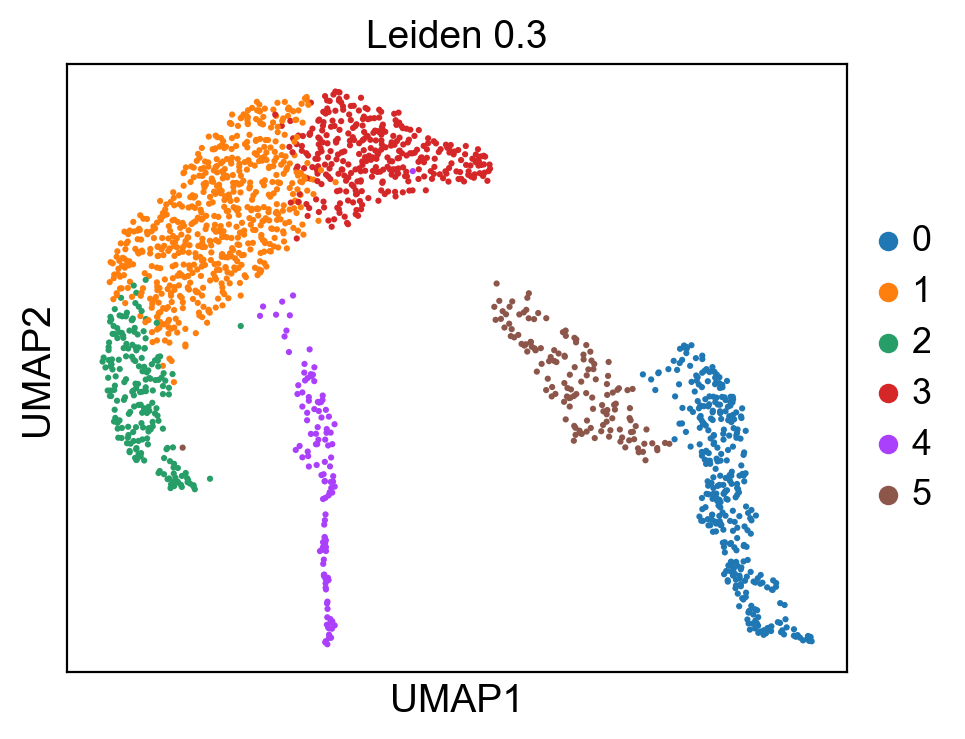

In [42]:
ep.settings.set_figure_params(figsize=(5, 4), dpi=100)
ep.pl.umap(edata, color=["leiden_0_3"], title="Leiden 0.3", size=20)

This UMAP embedding is exactly the same as previously computed in the MIMIC-II IAC introduction tutorial. Now we continue with the patient fate analysis.

_________________

## Analysis using ehrapy and CellRank

Depending on the data it may not always be possible to clearly define a cluster or specific patient visits as the origin or terminus of a trajectory. Working with single-cell data simplifies matters since the detection of stem cells generally signifies the start of cell differentiation.

In this tutorial, we will define a patient cluster as the origin (root cluster) and explore possible terminal states. 

### Pseudotime calculation

As the root cluster for pseudotime calculation we choose cluster 0 since patients in that cluster do not show very severe comorbidities and features yet. Then we calculate the [Diffusion Pseudotime](https://www.nature.com/articles/nmeth.3971).

In [43]:
edata = ad.AnnData(edata)

In [46]:
edata.uns["iroot"] = np.flatnonzero(edata.obs["leiden_0_3"] == "0")[0]
ep.tl.dpt(edata)

Now we define the kernel, compute the transition matrix and plot a projection onto the UMAP.

### Determining patient fate with a PseudotimeKernel

The [PseudotimeKernel](https://cellrank.readthedocs.io/en/latest/notebooks/tutorials/kernels/300_pseudotime.html) computes direct transition probabilities based on a KNN graph and pseudotime.

The KNN graph contains information about the (undirected) conductivities among patients, reflecting their similarity. Pseudotime can be used to either remove edges that point against the direction of increasing pseudotime, or to downweight them.

In [49]:
from cellrank.kernels import PseudotimeKernel

pk = PseudotimeKernel(edata, time_key="dpt_pseudotime")
pk.compute_transition_matrix()

  0%|          | 0/1776 [00:00<?, ?cell/s]

PseudotimeKernel[n=1776, dnorm=False, scheme='hard', frac_to_keep=0.3]

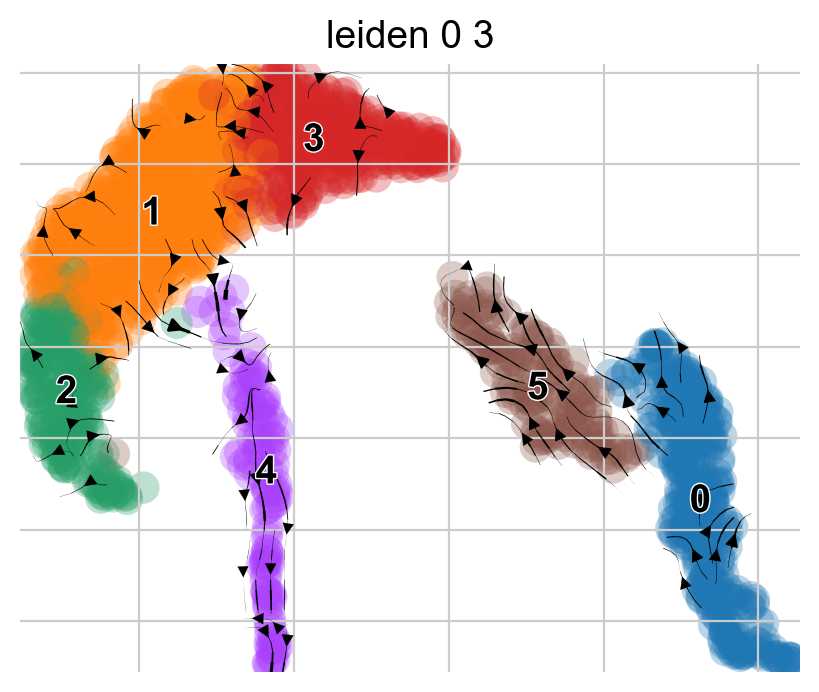

In [50]:
ep.settings.set_figure_params(figsize=(5, 4), dpi=100)
pk.plot_projection(basis="umap", color="leiden_0_3")

We observe two main trajectories originating from cluster 0 going to clusters 2, 3, and 5. Let's check the metedata again. 

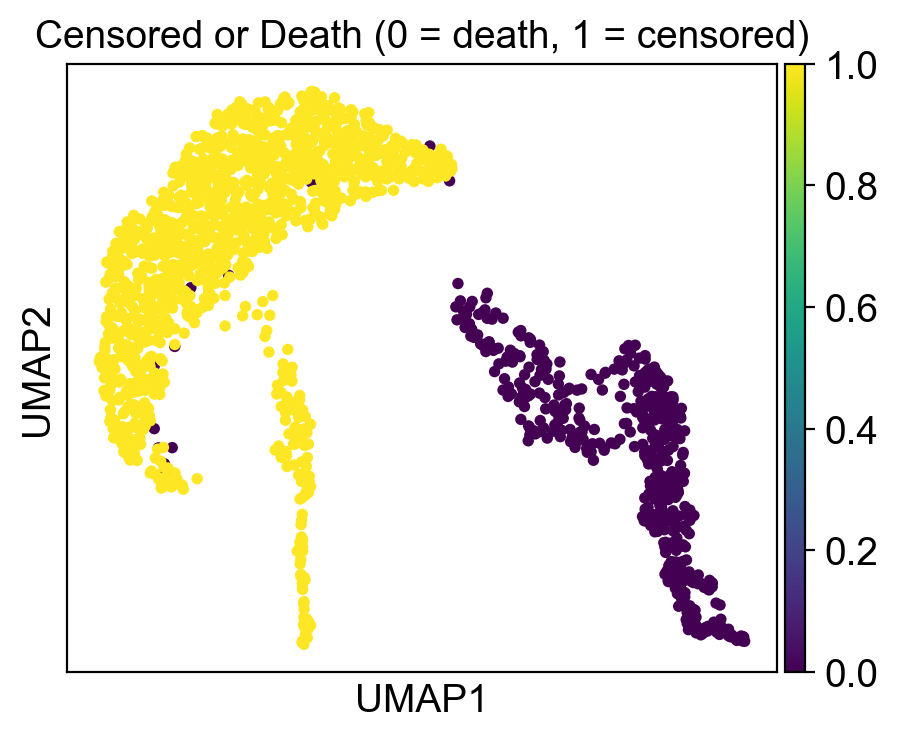

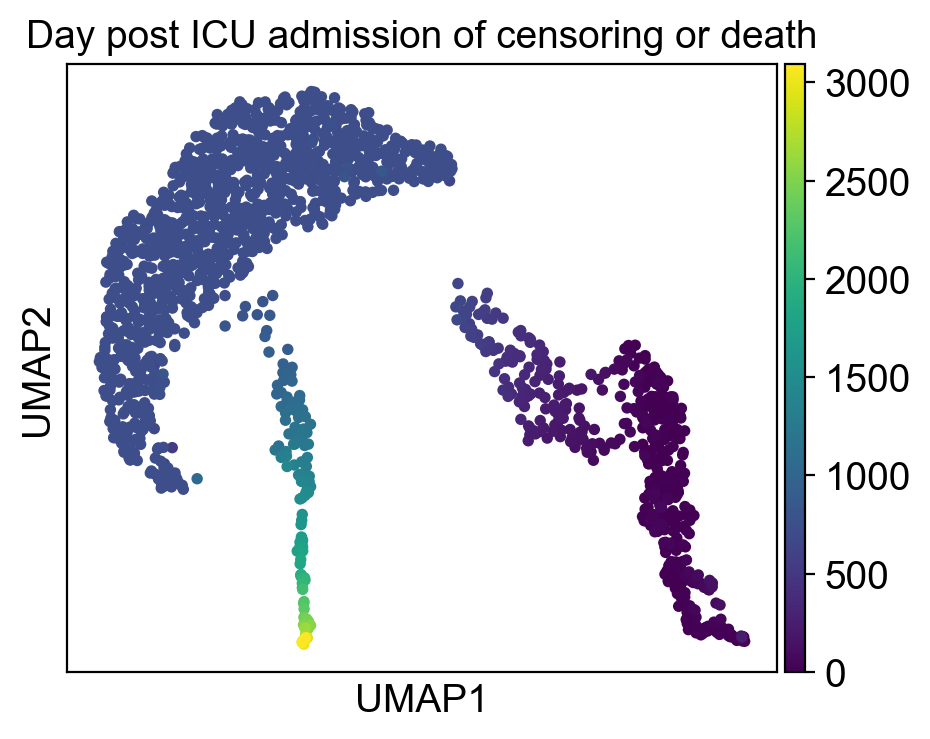

In [51]:
ep.pl.umap(edata, color="censor_flg", title="Censored or Death (0 = death, 1 = censored)")
ep.pl.umap(
    edata,
    color="mort_day_censored",
    title="Day post ICU admission of censoring or death",
)

Cluster 4 and 1 consist of patients that deceased, while cluster 5 includes patients with a high day post ICU admission. 

### Simulating transitions with random walks

Cellrank makes it easy to simulate the behavior of random walks from specific clusters.
This allows us to not only visualize where the patients end up, but also roughly how many in which clusters after a defined number of iterations.
We can either just start walking...

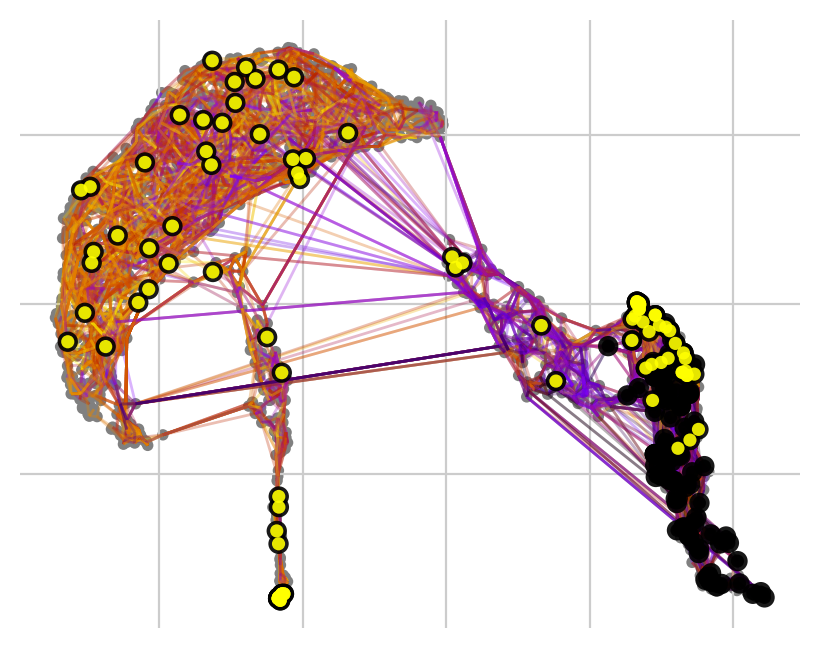

In [52]:
pk.plot_random_walks(
    seed=0,
    n_sims=100,
    start_ixs={"leiden_0_3": ["0"]},
    legend_loc="right",
    dpi=100,
    show_progress_bar=False,
)

... or set a number of required hits in one or more terminal clusters. Here, we require 50 hits in cluster 2 or 5.

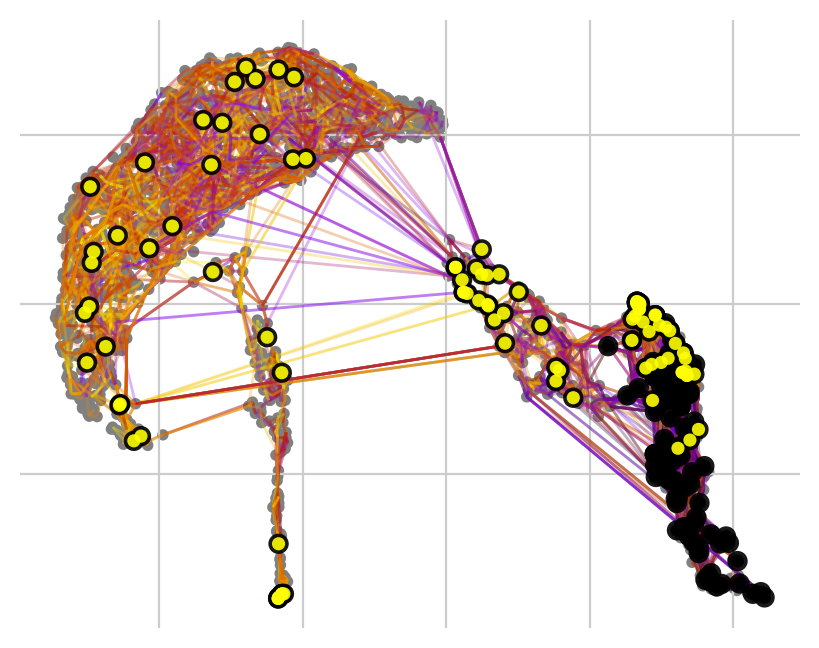

In [53]:
pk.plot_random_walks(
    seed=0,
    n_sims=100,
    start_ixs={"leiden_0_3": ["0"]},
    stop_ixs={"leiden_0_3": ["2", "5"]},
    successive_hits=50,
    legend_loc="right",
    dpi=100,
    show_progress_bar=False,
)

Black and yellow dots indicate random walk start and terminal patient visits, respectively.

### Determining macrostates and terminal states

To find the terminal states of cluster 0, well will use an estimator to predict the patient fates using the above calculated transition matrix. The main objective is to decompose the patient state space into a set of macrostates, that represent the slow-time scale dynamics of the process and predict terminal states. Here, we will use an [**G**eneralized **P**erron **C**luster **C**luster **A**nalysis (GPCCA)](https://cellrank.readthedocs.io/en/latest/api/_autosummary/estimators/cellrank.estimators.GPCCA.html#cellrank.estimators.GPCCA) estimator.

As a first step we try to identify macrostates in the data using the `fit()` function.

In [54]:
# Check if pseudotime was computed
print("Pseudotime key exists:", "dpt_pseudotime" in edata.obs)
if "dpt_pseudotime" in edata.obs:
    print("Pseudotime range:", edata.obs["dpt_pseudotime"].min(), "to", edata.obs["dpt_pseudotime"].max())
    print("Any NaN values:", edata.obs["dpt_pseudotime"].isna().sum())

Pseudotime key exists: True
Pseudotime range: 0.0 to 1.0
Any NaN values: 0


In [55]:
g = cr.estimators.GPCCA(pk)
g.fit(cluster_key="leiden_0_3")
g.macrostates_memberships

Lineage([[9.5350518614e-03, 4.9677248301e-01, 4.9369246512e-01],
         [2.4634111382e-01, 7.5365662246e-01, 2.2637198736e-06],
         [2.1773391689e-01, 7.8226445628e-01, 1.6268345193e-06],
         ...,
         [2.1111670209e-02, 9.2639025335e-02, 8.8624930446e-01],
         [1.9294616154e-01, 7.8930781450e-01, 1.7746023962e-02],
         [2.2426883226e-01, 7.7573004074e-01, 1.1269932741e-06]],
  names([4, 0_1, 0_2]))

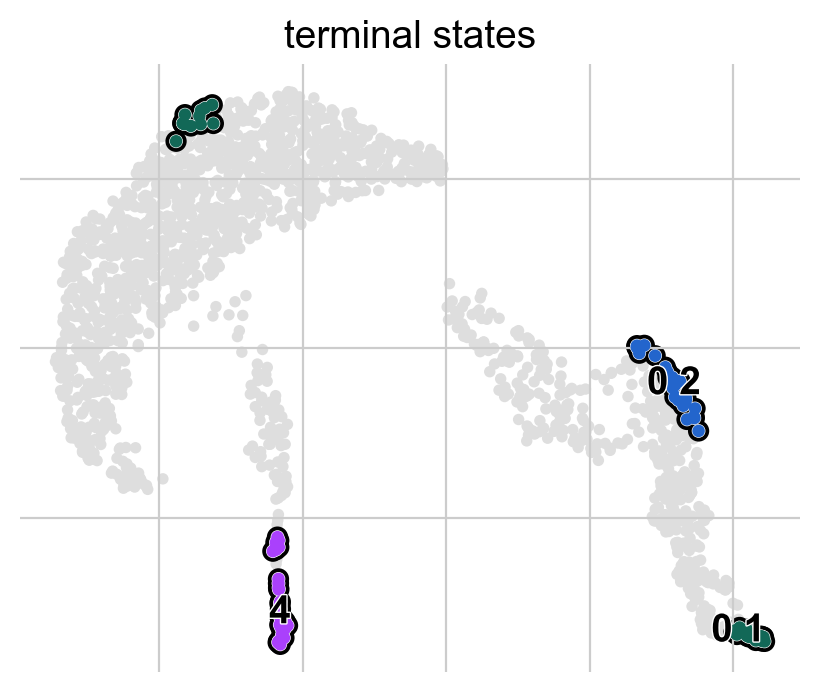

In [56]:
g.predict_terminal_states()
g.plot_macrostates(which="terminal")

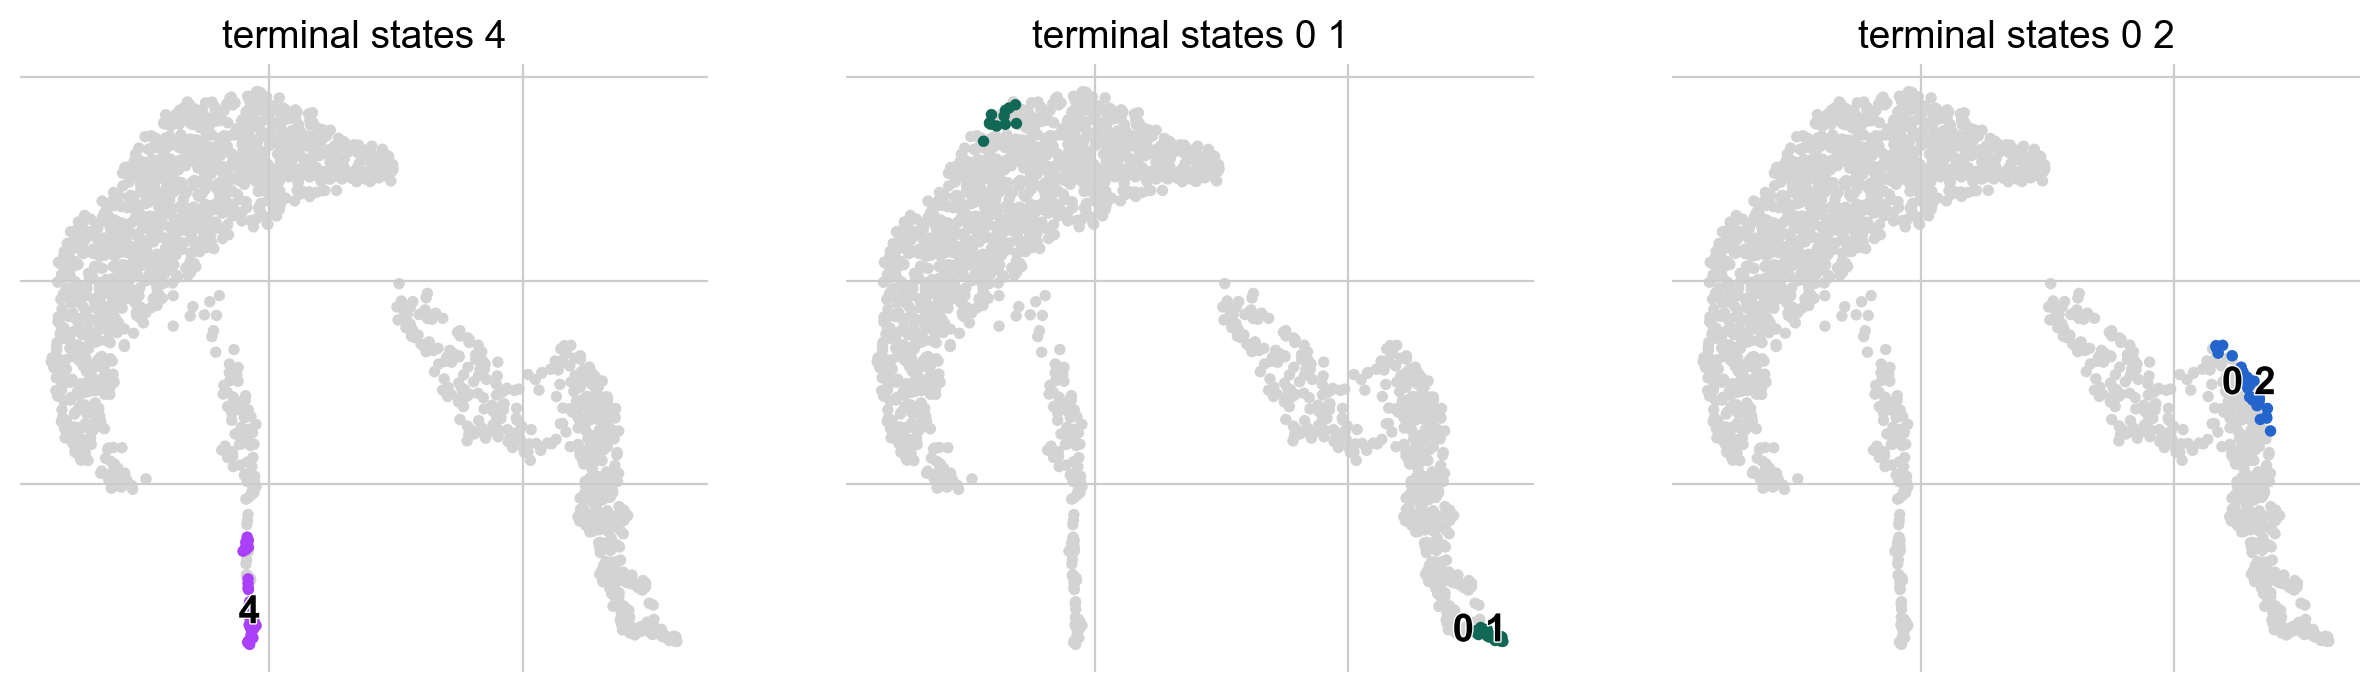

In [57]:
g.plot_macrostates(which="terminal", same_plot=False)

As a next step we will calculate the fate probabilities. For each patient visit, this computes the probability of being absorbed in any of the terminal states by aggregating over all random walks that start in a given patient visit and end in some terminal population. 

  0%|          | 0/3 [00:00<?, ?/s]

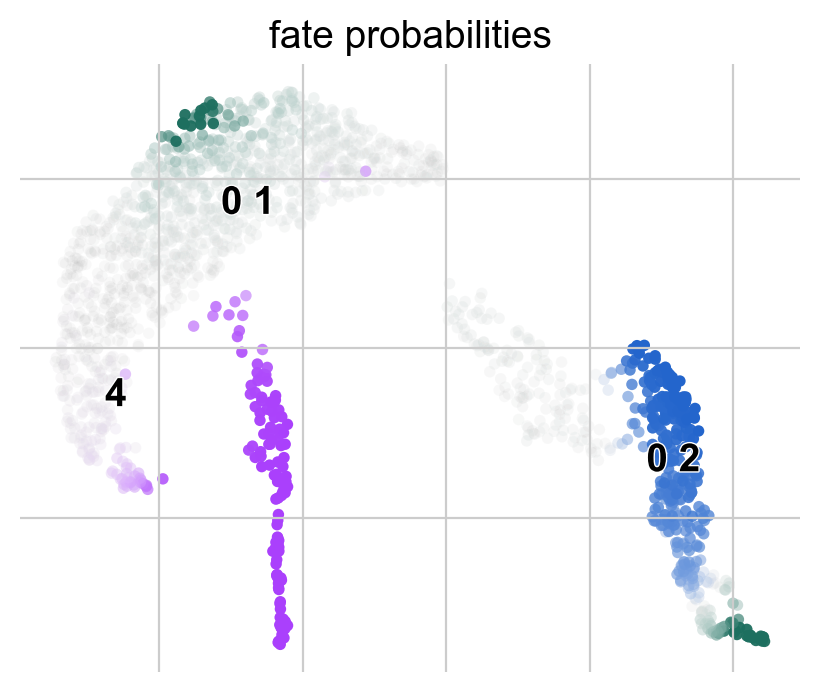

In [58]:
g.compute_fate_probabilities(preconditioner="ilu", tol=1e-15)
g.plot_fate_probabilities()

The plot above combines fate probabilities towards all terminal states, each patient visit is colored according to its most likely fate, color intensity reflects the degree of fate priming.

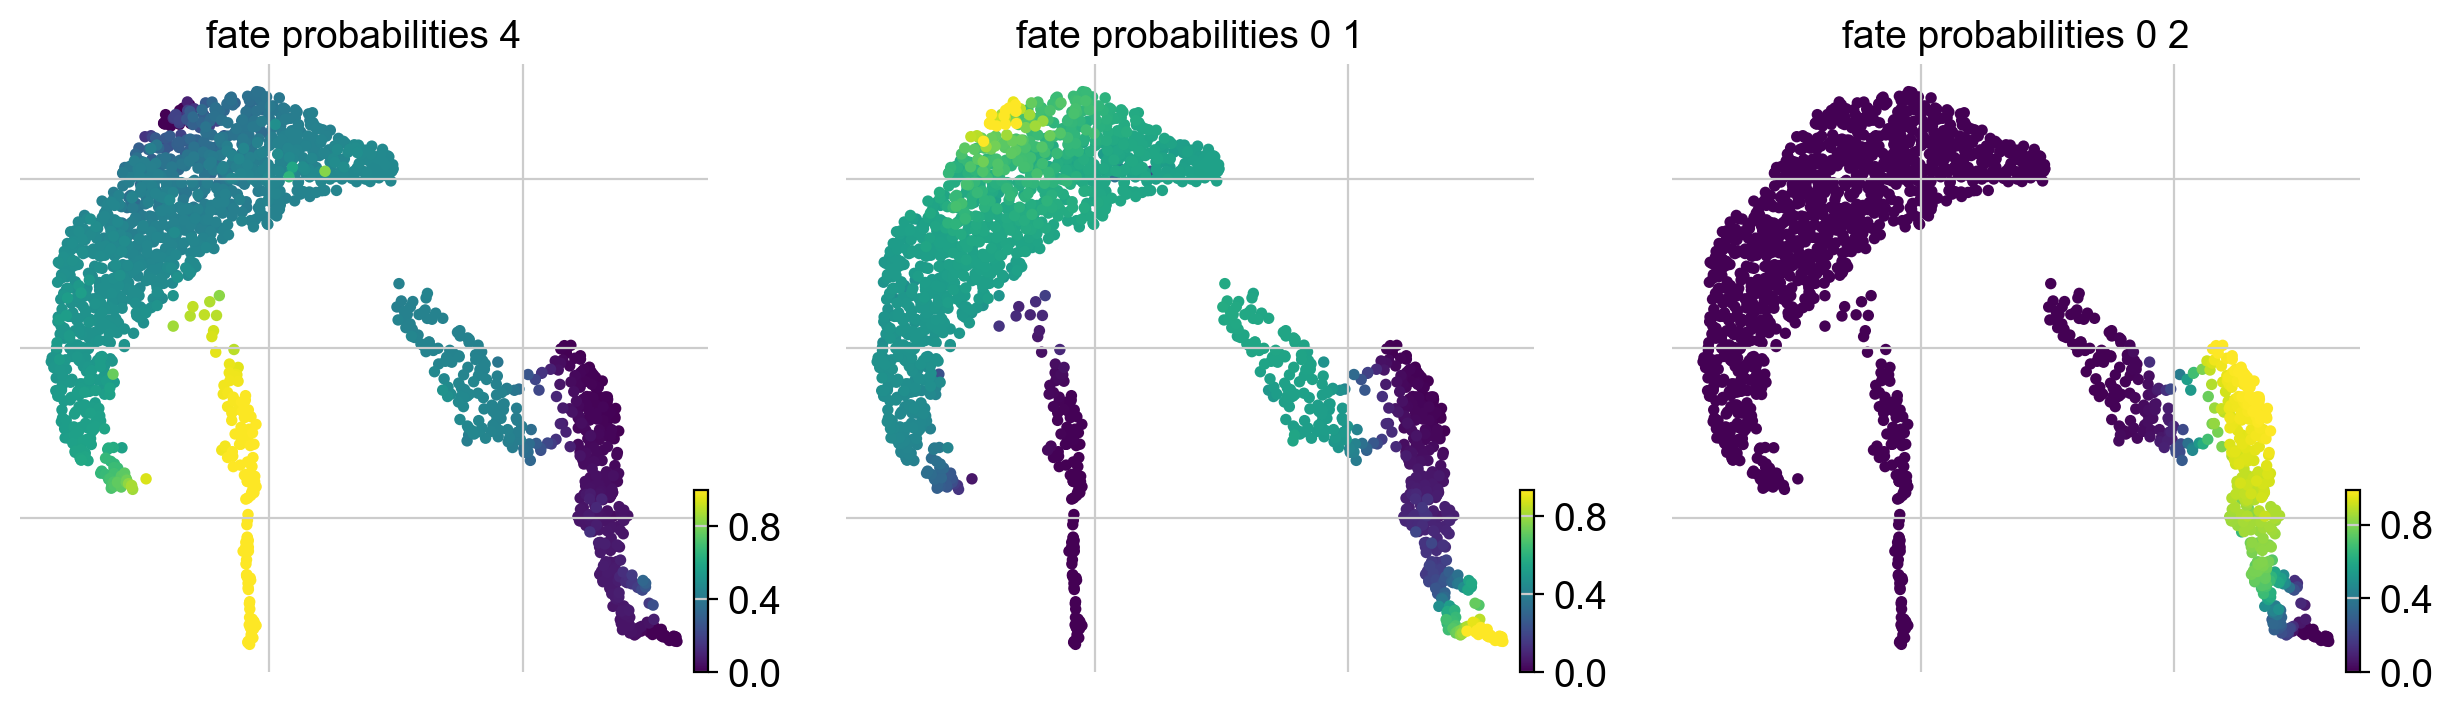

In [59]:
g.plot_fate_probabilities(same_plot=False)

We can also visualize the fate probabilities jointly in a circular projection where each dot represents a patient visit, colored by cluster labels. Patient visits are arranged inside the circle according to their fate probabilities, fate biased visits are placed next to their corresponding corner while undetermined patient fates are placed in the middle.

In [60]:
edata.obsm

AxisArrays with keys: X_pca, X_umap, X_diffmap, T_fwd_umap, schur_vectors_fwd, macrostates_fwd_memberships, term_states_fwd_memberships, lineages_fwd

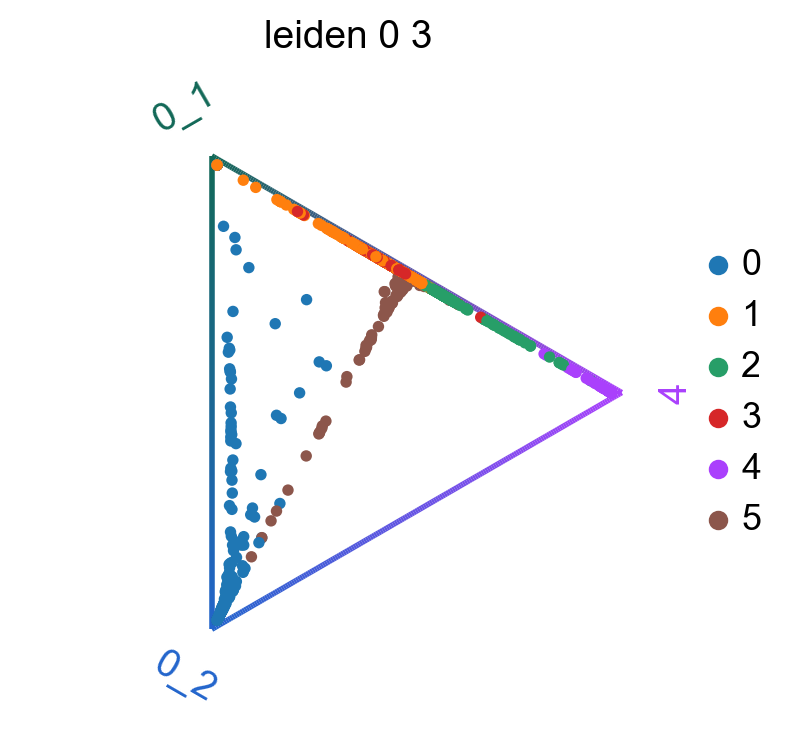

In [61]:
cr.pl.circular_projection(edata, keys="leiden_0_3", legend_loc="right")

### Identification of driver features

We uncover putative driver features by correlating fate probabilities with features using the `compute_lineage_drivers()` method. In other words, if a feature is systematically higher or lower in patient visits that are more or less likely to differentiate towards a given terminal state, respectively, then we call this feature a putative driver feature.

We calculate these driver features for our lineages:

In [62]:
%%capture
ep.settings.set_figure_params(figsize=(3, 3), dpi=100)

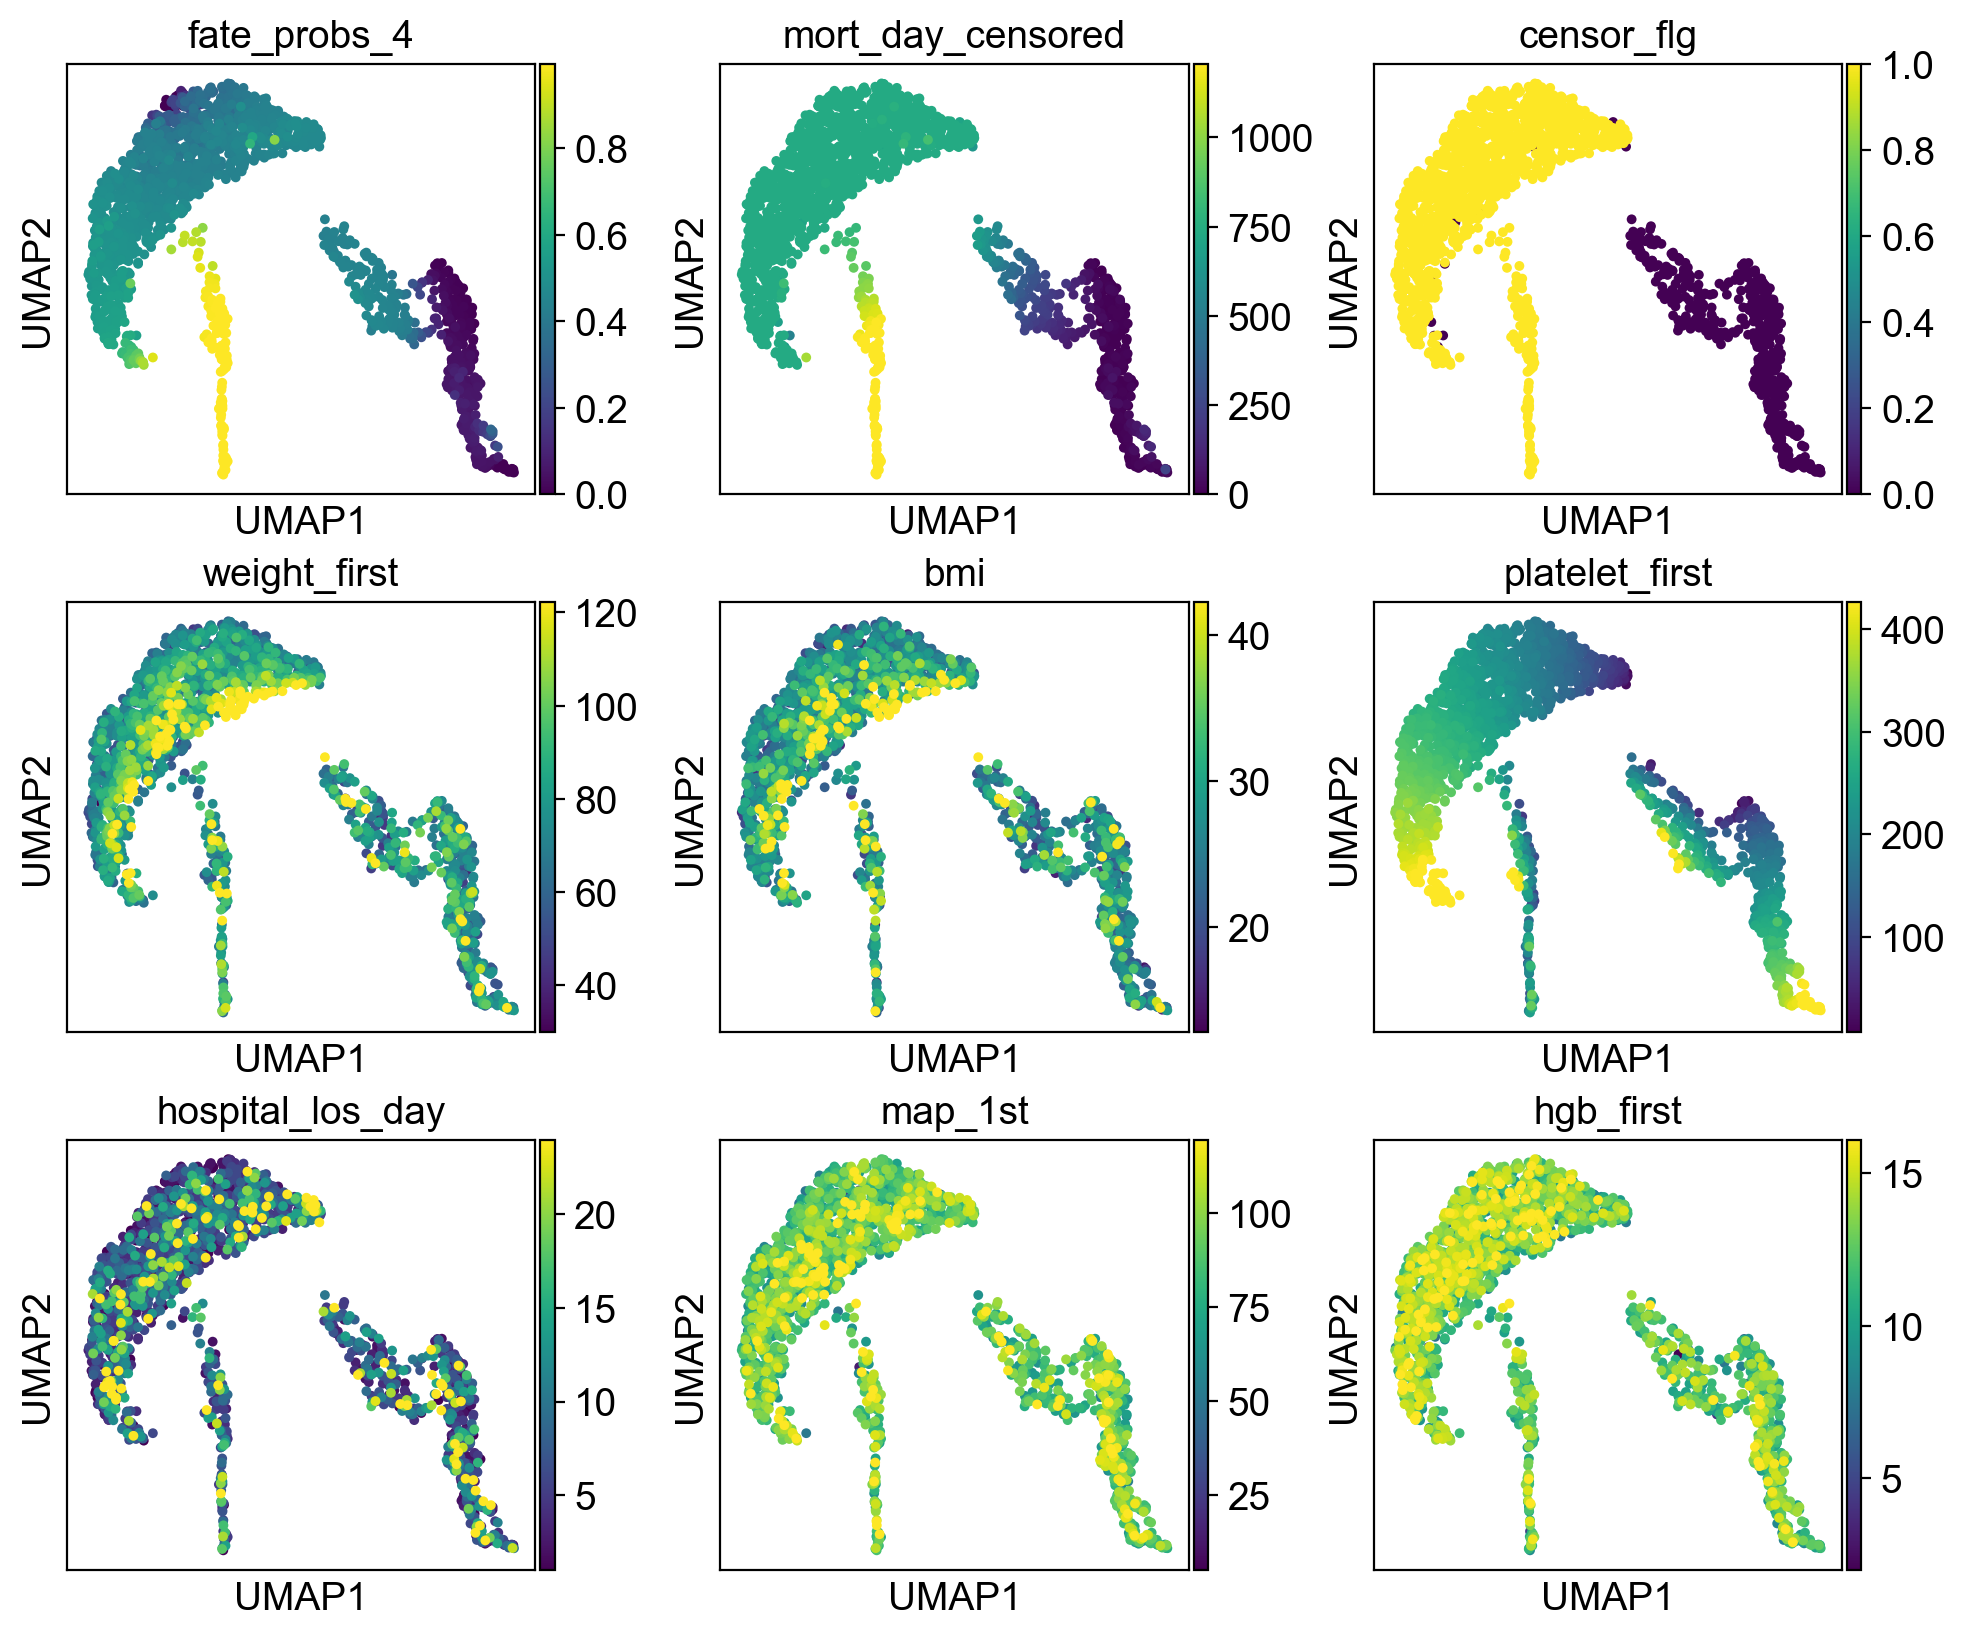

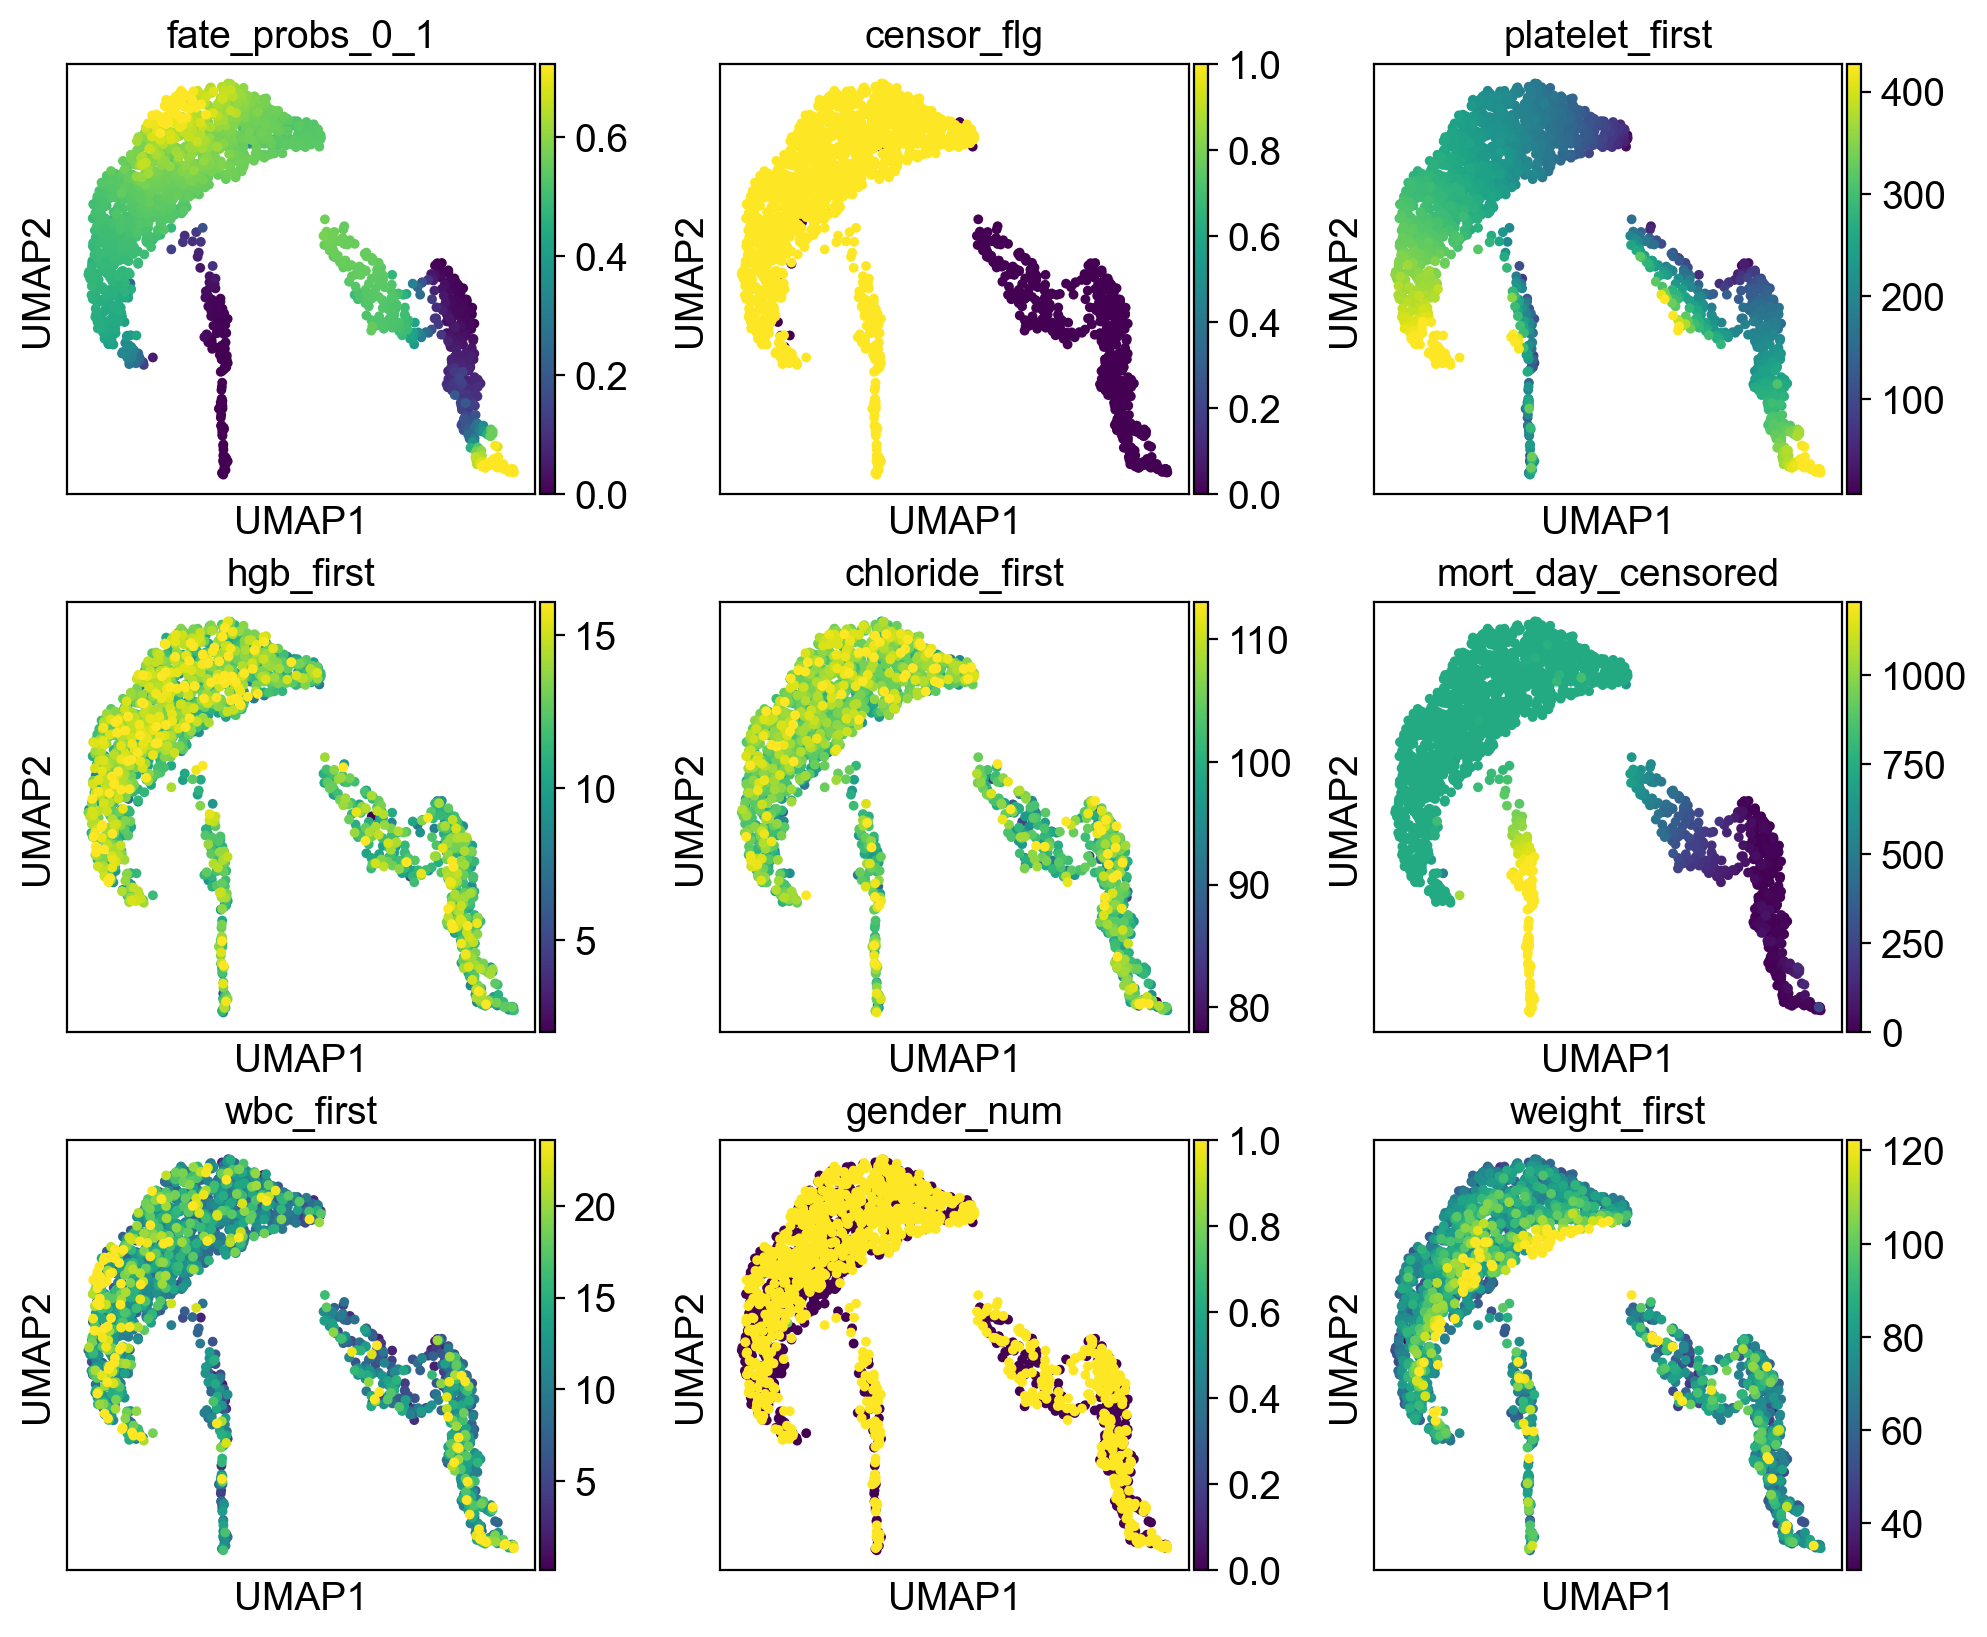

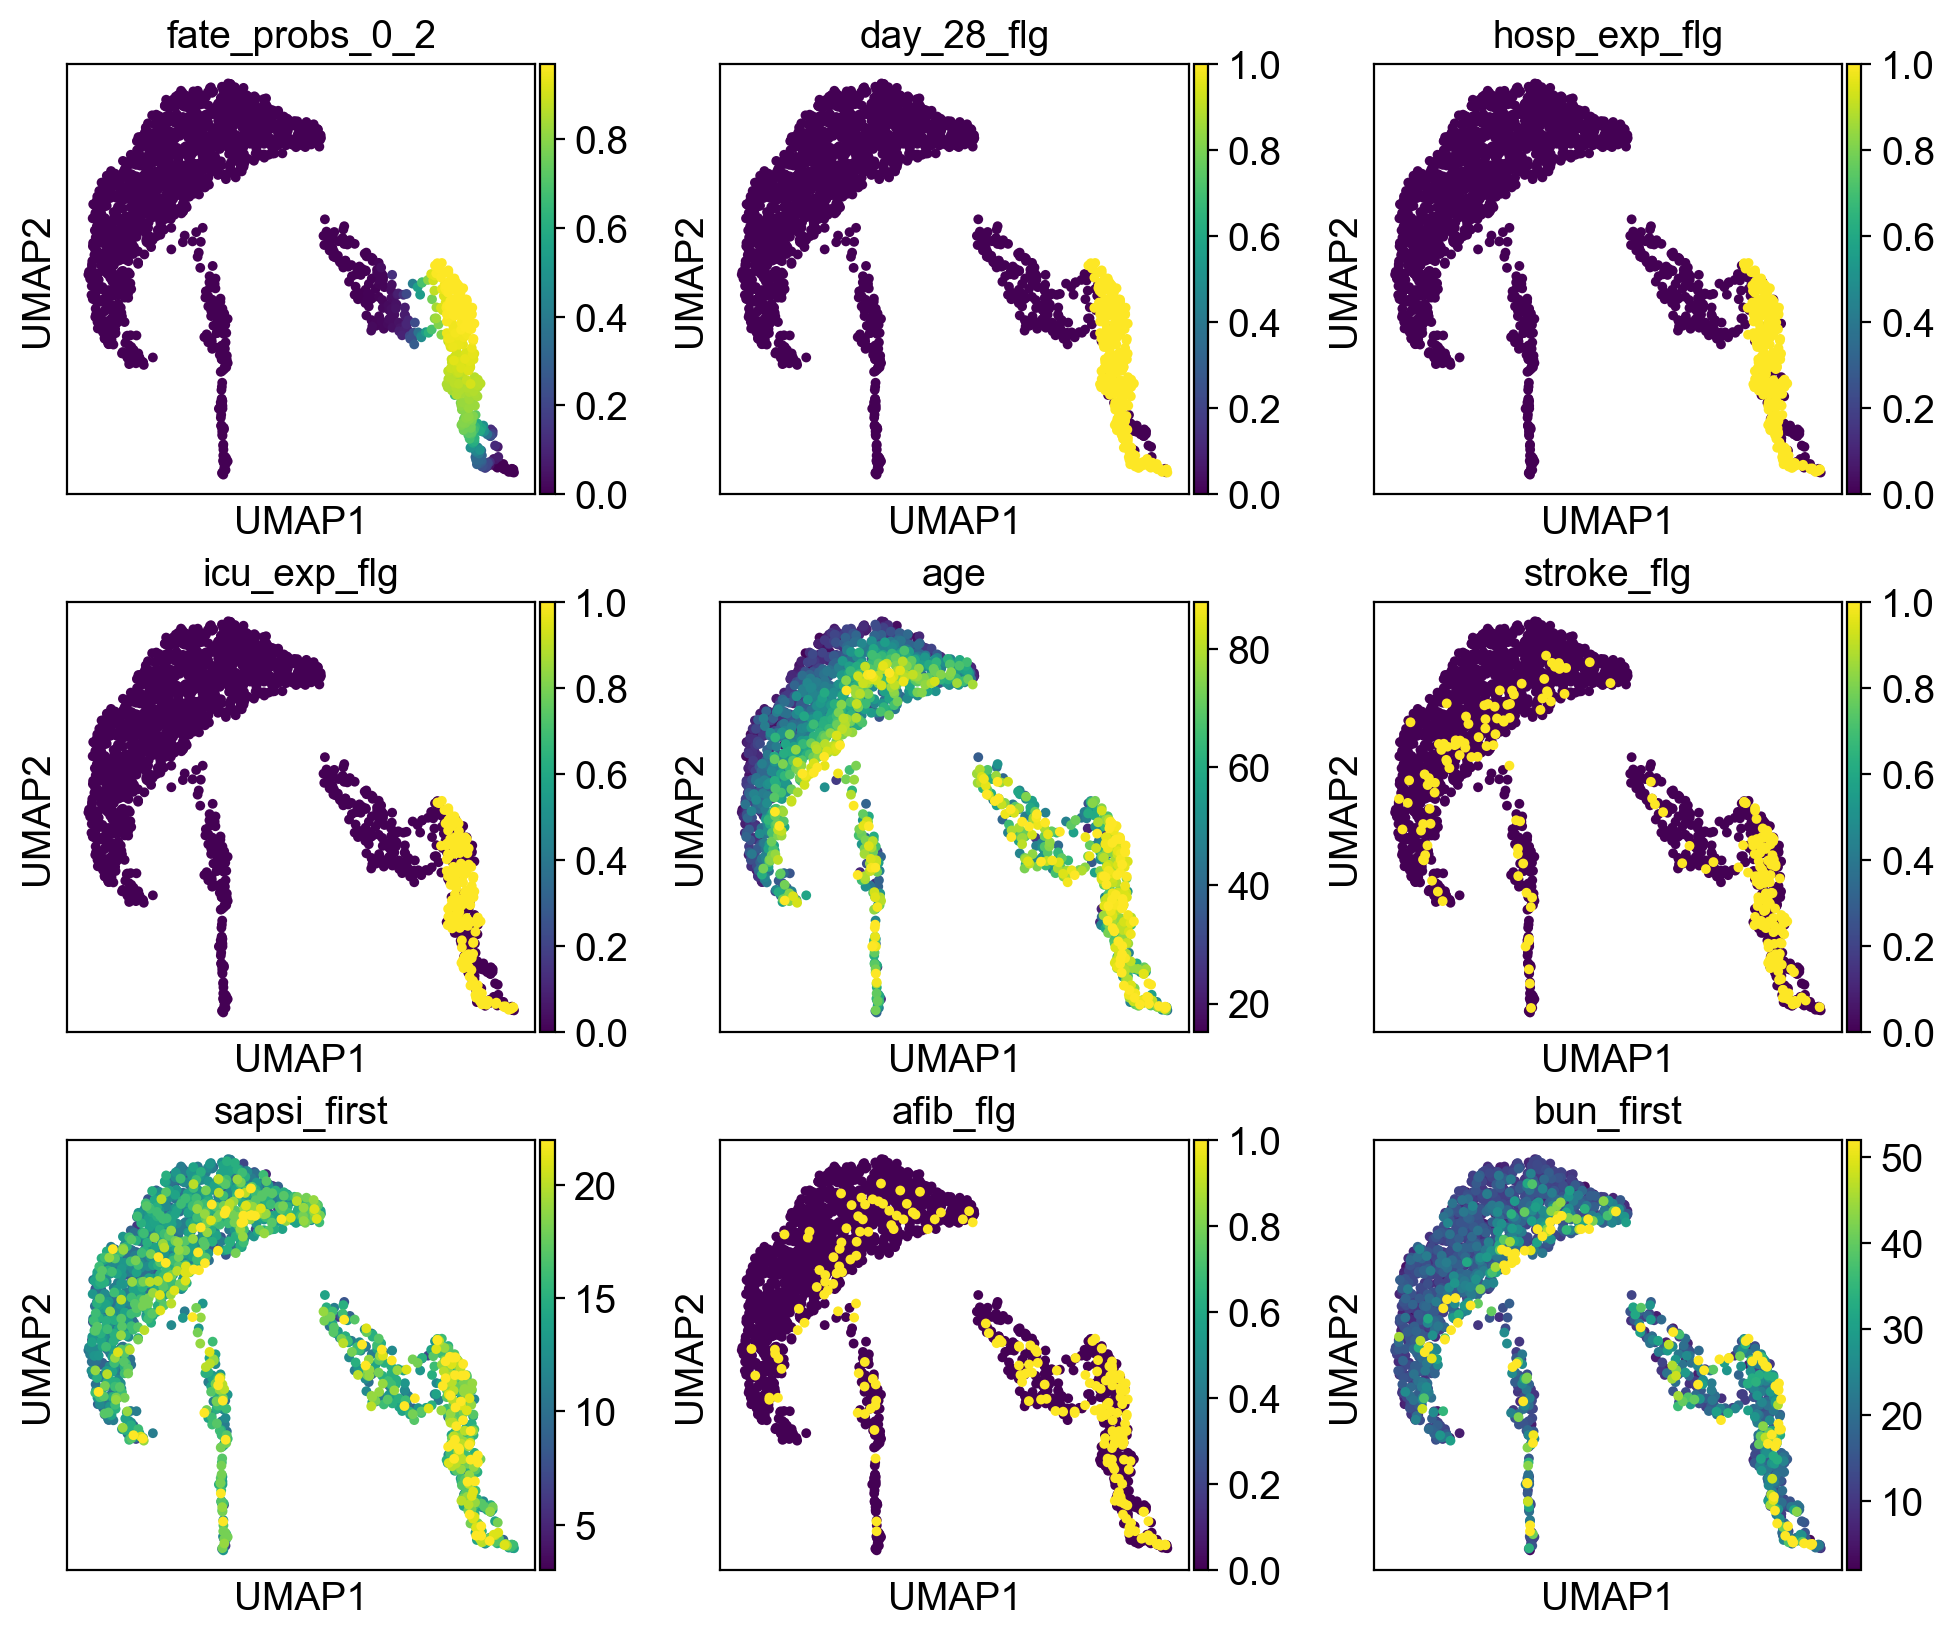

In [64]:
for lineage in g.macrostates_memberships._names:
    drivers = g.compute_lineage_drivers(lineages=lineage)
    edata.obs[f"fate_probs_{lineage}"] = g.fate_probabilities[lineage].X.flatten()

    ep.pl.umap(
        edata,
        color=[f"fate_probs_{lineage}"] + list(drivers.index[:8]),
        color_map="viridis",
        s=50,
        ncols=3,
        vmax="p96",
    )

The lineage `1_1` seems to have a lot of patients that deceased in hospital, are of high age and had a high platelet measurement, while lineage `1_2` consists of patients that deceased in hospital, had a high first SAPS I and SOFA score and lineage `5` consists of patients with a high number of days after ICU release.

### Determining feature trends

Given fate probabilities and a pseudotime, we can plot trajectory-specific feature trends. Specifically, we fit [Generalized Additive Models (GAMs)](https://en.wikipedia.org/wiki/Generalized_additive_model), weighting each observation's (here patients) contribution to each trajectory according to its vector of fate probabilities. We start by initializing a `model`.

In [65]:
model = cr.models.GAM(edata)

With the model initialized, we can visualize feature dynamics along specific trajectories. Here, we have a closer look at a selection of features that were previously identified as lineage drivers.

  0%|          | 0/8 [00:00<?, ?gene/s]

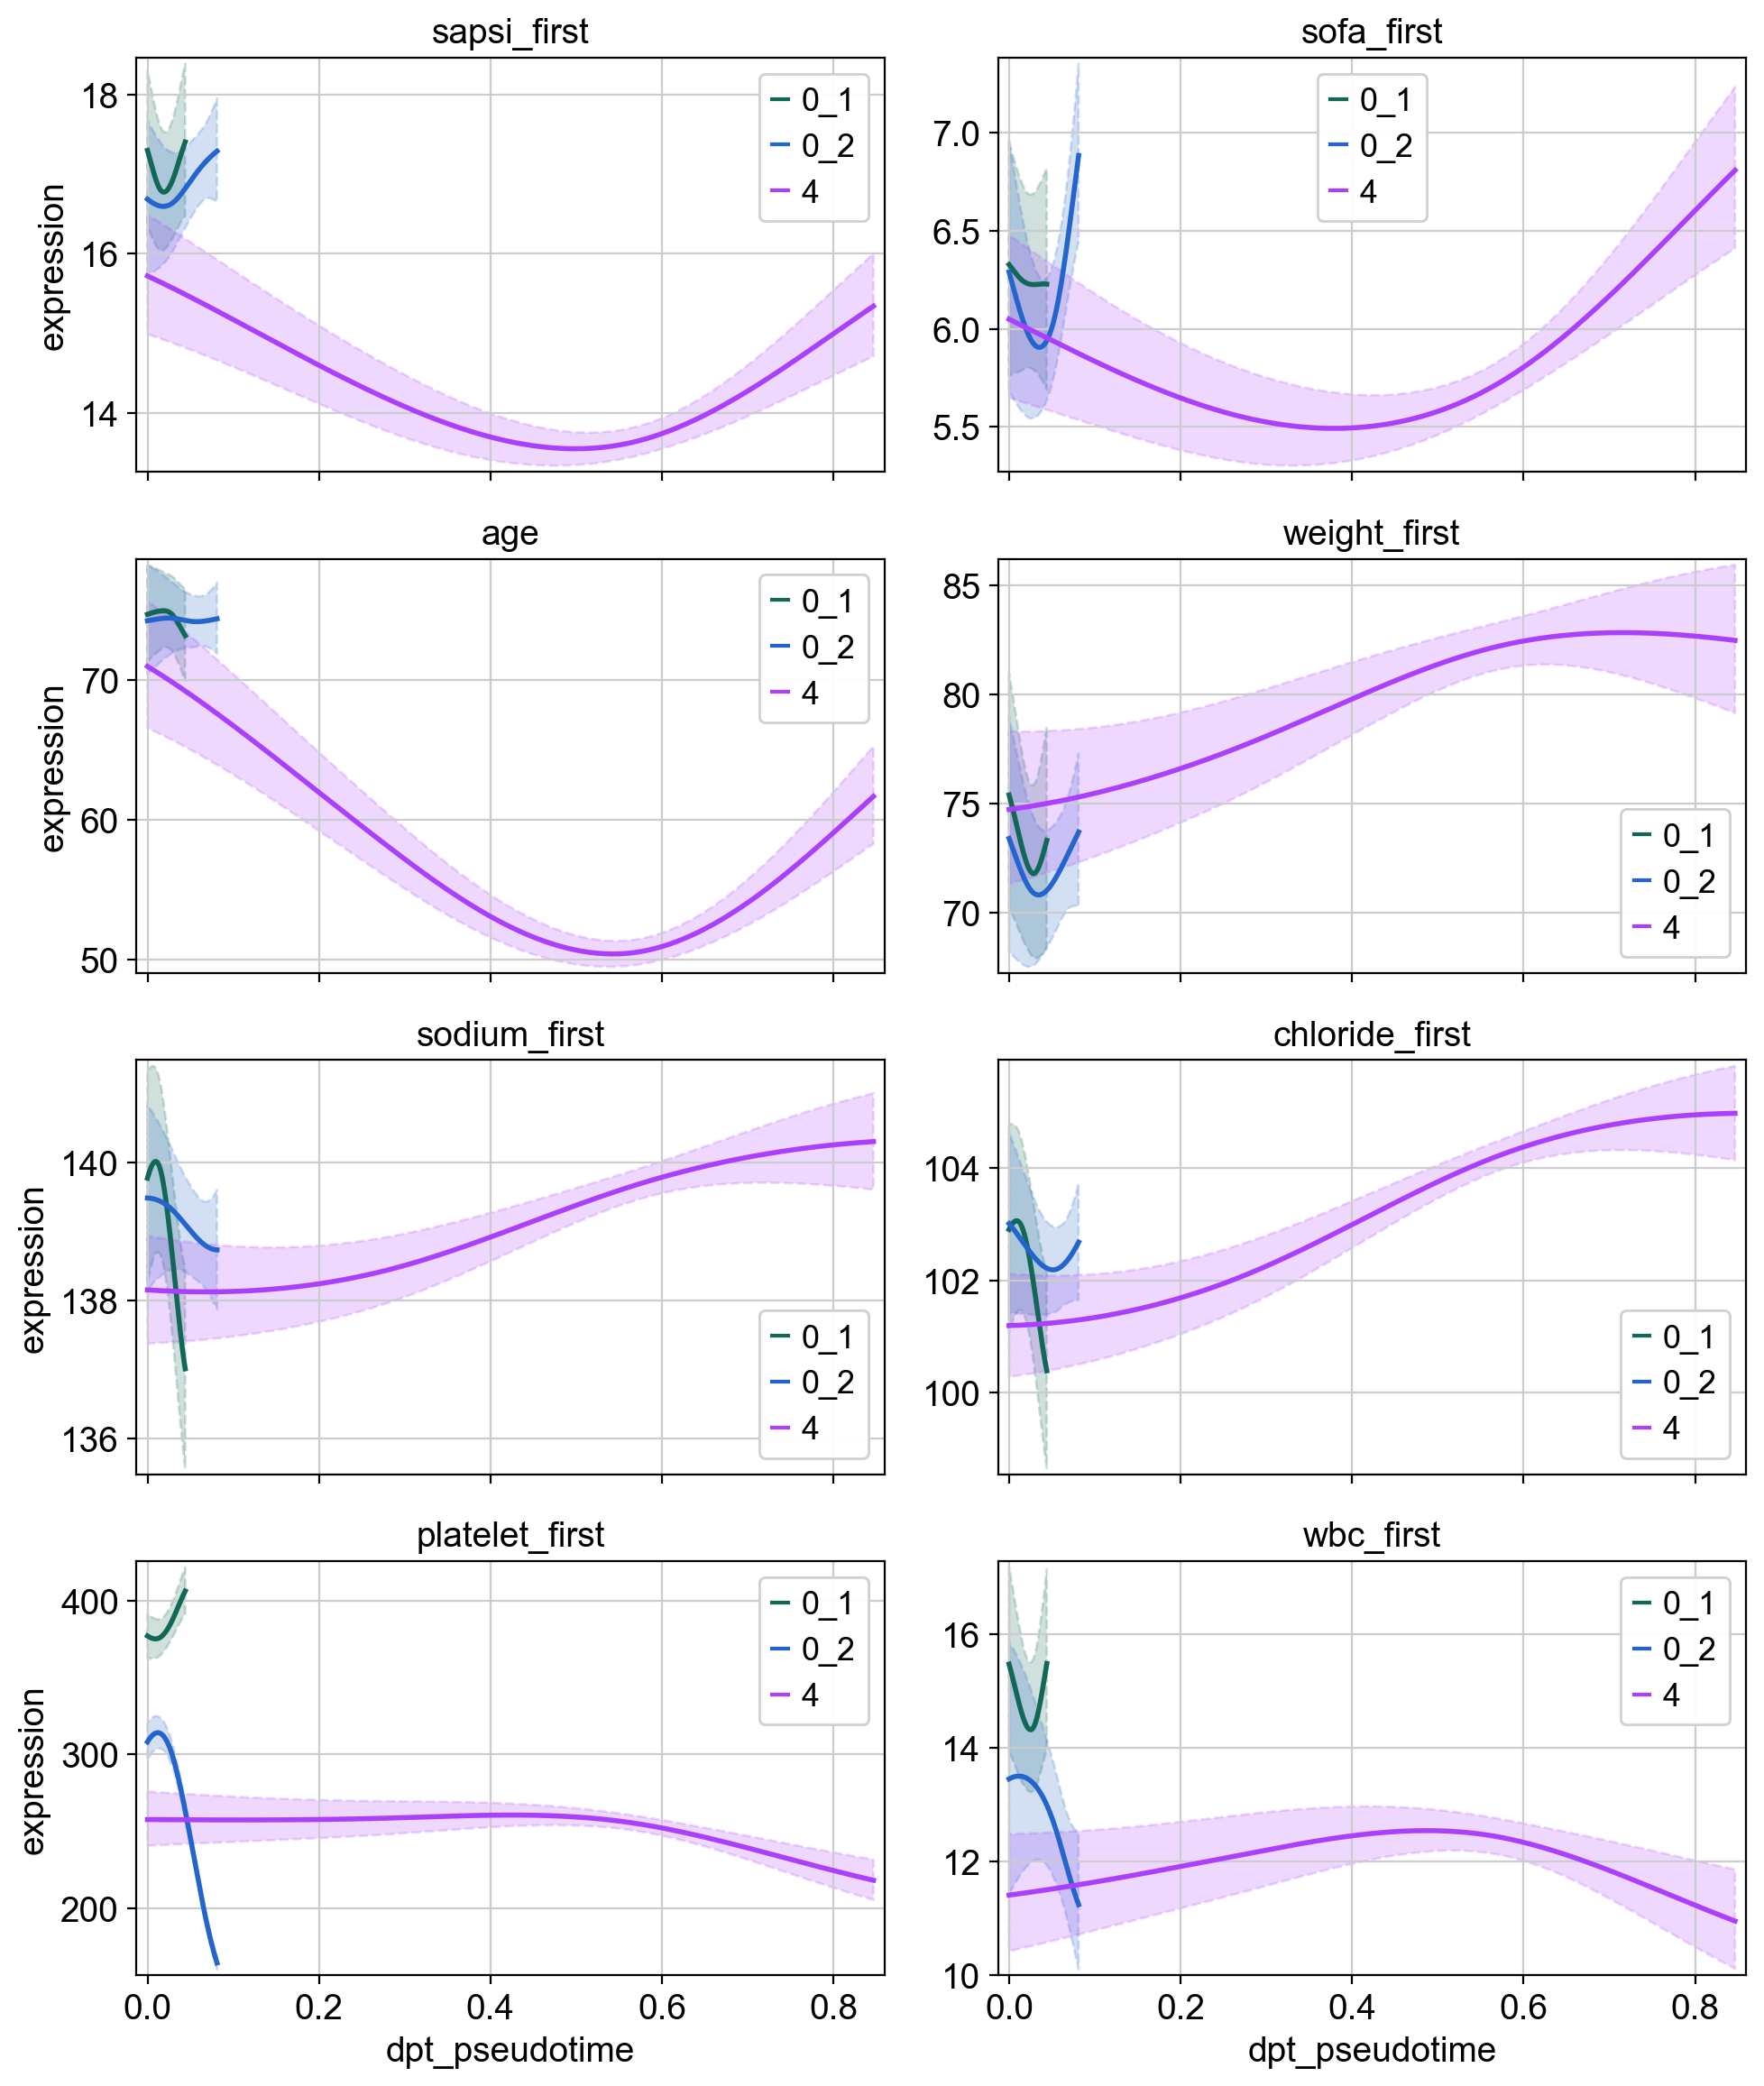

In [66]:
cr.pl.gene_trends(
    edata,
    model,
    [
        "sapsi_first",
        "sofa_first",
        "age",
        "weight_first",
        "sodium_first",
        "chloride_first",
        "platelet_first",
        "wbc_first",
    ],
    time_key="dpt_pseudotime",
    show_progress_bar=False,
    same_plot=True,
    ncols=2,
    hide_cells=True,
    figsize=(10, 12),
)

_________________

## Conclusion

In this tutorial we applied CellRank and ehrapy to identify patient visit trajectories from selected root clusters, computed macrostates of clusters and pointed out features that are driving those trajectories. Following that, we visualized feature trends across the pseudotime for the patient trajectories. In particular, we inspected trajectories of patients originating from cluster 0, which was defined by less severe features, and identified 3 major trajectories. Two trajectories (2_1 and 2_2) were terminated in a bad outcome cluster and were driven by severity features such as age, death and comorbidities.

As a next tutorial, we suggest to have a closer look at our [survival analysis](https://ehrapy.readthedocs.io/en/latest/tutorials/notebooks/mimic_2_survival_analysis.html), continue with that tutorials or go back to our [tutorial overview page](https://ehrapy.readthedocs.io/en/latest/tutorials/index.html). 

_________________

## References

* Raffa, J. (2016). Clinical data from the MIMIC-II database for a case study on indwelling arterial catheters (version 1.0). PhysioNet. https://doi.org/10.13026/C2NC7F.

* Raffa J.D., Ghassemi M., Naumann T., Feng M., Hsu D. (2016) Data Analysis. In: Secondary Analysis of Electronic Health Records. Springer, Cham

* Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

* Marius Lange, Volker Bergen, Michal Klein, Manu Setty, Bernhard Reuter, Mostafa Bakhti, Heiko Lickert, Meshal Ansari, Janine Schniering, Herbert B. Schiller, Dana Pe'er, and Fabian J. Theis. Cellrank for directed single-cell fate mapping. Nat. Methods, 2022. doi:10.1038/s41592-021-01346-6.

* Lars Velten, Simon F. Haas, Simon Raffel, Sandra Blaszkiewicz, Saiful Islam, Bianca P. Hennig, Christoph Hirche, Christoph Lutz, Eike C. Buss, Daniel Nowak, Tobias Boch, Wolf-Karsten Hofmann, Anthony D. Ho, Wolfgang Huber, Andreas Trumpp, Marieke A. G. Essers, and Lars M. Steinmetz. Human haematopoietic stem cell lineage commitment is a continuous process. Nature Cell Biology, 19(4):271–281, 2017. doi:10.1038/ncb3493.

* Bergen, V., Lange, M., Peidli, S. et al. Generalizing RNA velocity to transient cell states through dynamical modeling. Nat Biotechnol 38, 1408–1414 (2020). https://doi.org/10.1038/s41587-020-0591-3

* Haghverdi, L., Büttner, M., Wolf, F. et al. Diffusion pseudotime robustly reconstructs lineage branching. Nat Methods 13, 845–848 (2016). https://doi.org/10.1038/nmeth.3971

_________________

## Package versions

In [67]:
ep.print_versions()

anndata 0.11.3
cellrank        2.0.7
numpy   1.26.4
pandas  2.2.3
----    ----
db-dtypes       1.4.2
pyasn1  0.6.1
tblib   3.0.0
scipy   1.14.1
prompt_toolkit  3.0.50
interface-meta  1.3.0
jupyter_client  8.6.3
sparse  0.15.5
grpcio  1.71.0rc2
seaborn 0.13.2
numcodecs       0.15.1
sphinxcontrib-qthelp    2.0.0
importlib_metadata      8.6.1
dask    2025.2.0
joblib  1.4.2
fhiry   4.0.0
tabulate        0.9.0
google-api-core 2.24.1
xarray  2025.1.2
rich    13.9.4
six     1.17.0
tableone        0.9.1
pynndescent     0.5.13
cffi    1.17.1
pytest  8.3.5
progressbar2    4.5.0
Cython  0.29.37
zarr    2.18.4
pure_eval       0.2.3
pycparser       2.22
sphinxcontrib-devhelp   2.0.0
google-resumable-media  2.7.2
Jinja2  3.0.3
sphinxcontrib-htmlhelp  2.1.0
ipywidgets      8.1.5
Django  5.1.7
h5py    3.13.0
statsmodels     0.14.4
scikit-learn    1.6.1
threadpoolctl   3.5.0
pytz    2025.1
docrep  0.3.2
asciitree       0.3.3
google-cloud-core       2.4.2
lamin_utils     0.13.10
Pygments        2.19.1
python-dateutil 2.9.0.post0
wcwidth 0.2.13
coverage        7.6.12
session-info2   0.1.2
regex   2024.11.6 (2.5.148)
RapidFuzz       3.12.2
MarkupSafe      3.0.2
jedi    0.19.2
jupyter_core    5.7.2
stack-data      0.6.3
natsort 8.4.0
sphinxcontrib-bibtex    2.6.3
formulaic       1.1.1
packaging       24.2
idna    3.10
toolz   1.0.0
zstandard       0.23.0
decorator       5.2.1
networkx        3.4.2
google-cloud-bigquery   3.30.0
sphinxcontrib-serializinghtml   2.0.0
prodict 0.8.20
matplotlib-inline       0.1.7
ipykernel       6.29.5
Deprecated      1.2.18
parso   0.8.4
google-auth     2.38.0
awkward 2.7.4
umap-learn      0.5.7
setuptools      75.8.0
cycler  0.12.1
numba   0.61.0
pluggy  1.5.0
sphinxcontrib-jsmath    1.0.1
msgpack 1.1.0
defusedxml      0.7.1
llvmlite        0.44.0
imbalanced-learn        0.13.0
pyarrow 19.0.1
pyzmq   26.2.1
autograd        1.7.0
platformdirs    4.3.6
iniconfig       2.0.0
Bottleneck      1.5.0
comm    0.2.2
chardet 5.2.0
texttable       1.7.0
traitlets       5.14.3
scanpy  1.10.4
scvelo  0.3.3
wrapt   1.17.2
filelock        3.17.0
pyparsing       3.2.1
pygpcca 1.0.4
protobuf        5.29.3
executing       2.2.0
thefuzz 0.22.1
autograd-gamma  0.5.0
patsy   1.0.1
pexpect 4.9.0
awkward_cpp     44
python-utils    3.9.1
fsspec  2025.2.0
sphinxcontrib-applehelp 2.0.0
zipp    3.21.0
typing_extensions       4.12.2
googleapis-common-protos        1.69.1
missingno       0.5.2
igraph  0.11.8
urllib3 1.26.20
timeago 1.0.16 (1.0.14)
leidenalg       0.10.2
tqdm    4.67.1
torch   2.6.0
lifelines       0.30.0
PyYAML  6.0.2
legacy-api-wrap 1.4.1
debugpy 1.8.13
psutil  7.0.0
rsa     4.9
tornado 6.4.2
kiwisolver      1.4.8
ptyprocess      0.7.0
certifi 2025.1.31 (2025.01.31)
fast-array-utils        1.2.1
asttokens       3.0.0
grpcio-status   1.71.0rc2
cloudpickle     3.1.1
pyasn1_modules  0.4.1
appnope 0.1.4
faiss-cpu       1.10.0
pygam   0.9.0 (0.8.0)
cachetools      5.5.2
pillow  11.1.0
duckdb  1.2.1
charset-normalizer      3.4.1
attrs   25.1.0
ipython 9.0.1
requests        2.32.3
pydot   3.0.4
matplotlib      3.10.1
fknni   1.2.0
array_api_compat        1.11.1
----    ----
Python  3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]
OS      macOS-15.3-arm64-arm-64bit
CPU     8 logical CPU cores, arm
GPU     No GPU found
Updated 2025-09-07 08:35